In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

In [2]:
# данные для подключения удалены в целях безопасности
db_config = {
    'user': '*****',
    'pwd': '*****',
    'host': '*****',
    'port': 0000,
    'db': '*****'
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [4]:
query = '''
SELECT DATE_TRUNC('month', creation_date) AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date)=2008
GROUP BY month_date
ORDER BY total_views DESC;
'''

df = pd.read_sql_query(query, con=engine) 
df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Меньше всего просмотров постов в июле 2015 года, именно тогда Stack Overflow объявил о запуске бета-тестирования русскоязычной версии сервиса. Больше всего просмотров в сентябре и октябре 2015 года - это связано с официальным запуском Stack Overflow.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [4]:
query = '''
WITH
comments AS (SELECT creation_date,
                    user_id
             FROM stackoverflow.posts
             WHERE parent_id <> 0),

names AS (SELECT u.display_name,
                 ROW_NUMBER() OVER(PARTITION BY u.id) AS rn
          FROM stackoverflow.users AS u
          JOIN comments AS c ON u.id=c.user_id
                            AND c.creation_date <= u.creation_date + INTERVAL '1 month'),
                            
filtered_names AS (SELECT DISTINCT display_name
                   FROM names
                   WHERE rn = 101)

SELECT n.display_name,
       COUNT(*)
FROM filtered_names AS n
JOIN stackoverflow.users AS u ON n.display_name=u.display_name
GROUP BY n.display_name
ORDER BY n.display_name;
'''

df = pd.read_sql_query(query, con=engine) 
df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
57,leppie,1
58,lomaxx,1
59,mattlant,1
60,paxdiablo,1


Какие аномалии наблюдаются в данных? О чём они говорят?

Судя по получившемуся списку имен, не все пользователи вводят настоящие данные при регистрации.

In [20]:
df['count'].value_counts()

1     57
3      1
8      1
19     1
20     1
33     1
Name: count, dtype: int64

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [6]:
query = '''
SELECT DATE_TRUNC('month', creation_date) AS month,
       COUNT(*)
FROM stackoverflow.posts
WHERE user_id IN (SELECT id
                  FROM stackoverflow.users
                  WHERE DATE_TRUNC('month', creation_date) = '2008-09-01'
                    AND id IN (SELECT user_id
                               FROM stackoverflow.posts
                               WHERE DATE_TRUNC('month', creation_date) = '2008-12-01'))
GROUP BY month
ORDER BY month DESC;
'''

df = pd.read_sql_query(query, con=engine) 
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

Среди записей встречаются посты, оставленные в августе 2008 года, хотя пользователи были зарегистрированы позже - в сентябре 2008 года. Это может быть связано с официальным запуском Stack Overflow в сентябре - посты, созданные во время бета-тестирования в августе 2008 года сохранились, а даты регистрации пользователей обновились.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [7]:
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id,
         creation_date;
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [8]:
query = '''
WITH
tmp AS (SELECT user_id,
               COUNT(*)
        FROM stackoverflow.posts
        WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
          AND user_id IN (SELECT user_id
                          FROM stackoverflow.posts
                          WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
                          GROUP BY user_id
                          HAVING COUNT(*) > 120)
        GROUP BY user_id, DATE_TRUNC('day', creation_date))
    
SELECT user_id,
       AVG(count) AS avg_daily
FROM tmp
GROUP BY user_id
ORDER BY avg_daily;
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [9]:
query = '''
WITH
tmp AS (SELECT DISTINCT creation_date::date,
               user_id
        FROM stackoverflow.posts
        WHERE DATE_TRUNC('day', creation_date) BETWEEN '2008-12-01'
                                                   AND '2008-12-07')

SELECT ROUND(COUNT(*) / (1.0 * COUNT(DISTINCT user_id))) AS result
FROM tmp;
'''

df = pd.read_sql_query(query, con=engine) 
df

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В период с 1 по 7 декабря 2008 года пользователи взаимодействовали в платформой в среднем 2 дня.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [10]:
query = '''
WITH
tmp AS (SELECT user_id,
               creation_date,
               LAG(EXTRACT(MONTH FROM creation_date), 2) OVER(PARTITION BY user_id ORDER BY creation_date)
        FROM stackoverflow.posts)

SELECT user_id,
       creation_date,
       CASE
           WHEN lag = 7 THEN 'July'
           WHEN lag = 8 THEN 'August'
           WHEN lag = 9 THEN 'September'
           WHEN lag = 10 THEN 'October'
           WHEN lag = 11 THEN 'November'
           WHEN lag = 12 THEN 'December'
           ELSE NULL
        END AS second_last_month
FROM tmp;
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [11]:
query = '''
WITH
profile AS (SELECT *,
                   COUNT(*) OVER(PARTITION BY cohort_dt) AS cohort_users_cnt
            FROM (SELECT DISTINCT user_id,
                         DATE_TRUNC('month', FIRST_VALUE(creation_date) OVER(PARTITION BY user_id ORDER BY creation_date)) AS cohort_dt
                  FROM stackoverflow.posts) AS p),
                         
sessions AS (SELECT DISTINCT user_id,
                    DATE_TRUNC('month', creation_date) AS session_date
             FROM stackoverflow.posts)
             
SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / p.cohort_users_cnt, 2) AS retention_rate
FROM profile AS p
JOIN sessions AS s ON p.user_id = s.user_id
GROUP BY p.cohort_dt,
         s.session_date,
         p.cohort_users_cnt;
'''

df = pd.read_sql_query(query, con=engine) 
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

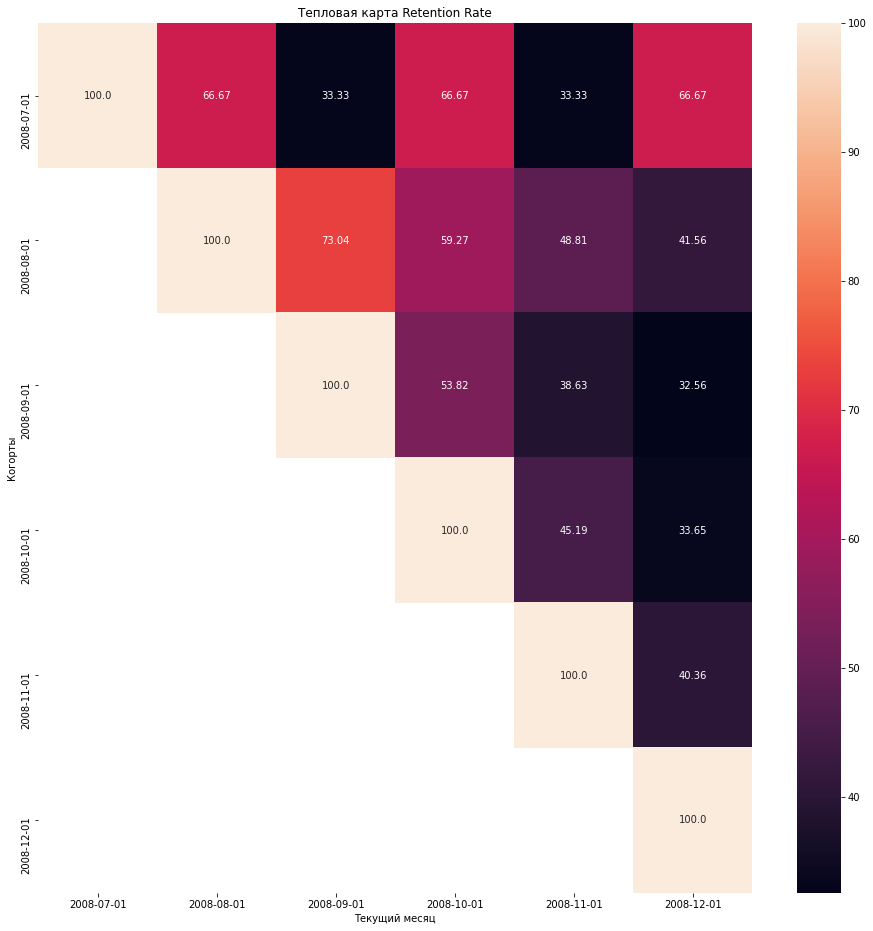

In [12]:
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(16, 16))
sns.heatmap(retention,
            annot=True,
            fmt='')
plt.title('Тепловая карта Retention Rate')
plt.xlabel('Текущий месяц')
plt.ylabel('Когорты')
plt.show() 

- в  когорте пользователей, пришедших в июле, значения 66.67 и 33.33 Retention Rate чередуются каждый месяц. Такие равные увеличения и уменьшения связаны с тем, что в когорте всего 3 пользователя и отсутствие/присутствие активности каждого из них влияет на 33.33%;
- самое высокое значение Retention Rate на второй месяц зафиксировано в когорте пользователей, пришедших в августе. Это может быть связано с официальным запуском StackOverflow в сентябре - большинству пользователей было интересно посмотреть на финальную версию проекта, задать свои вопросы и ответить на вопросы других пользователей;
- Retention Rate когорт пользователей, пришедших в сентябре и позднее, на второй месяц становится все меньше, по сравнению с каждой предыдушей когортой (53.82% для сентябрьской, 45.19% для октябрьской и 40.36% для ноябрьяской когорт) - возможно, влияет спад ажиотажа вокруг сервиса, а также уже успели накопиться ответы на самые популярные вопросы, так что пользователям реже приходится создавать новые посты.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [13]:
query = '''
WITH
tmp AS (SELECT EXTRACT(MONTH FROM creation_date)::int AS creation_month,
               COUNT(*) AS posts_count
        FROM stackoverflow.posts
        WHERE DATE_TRUNC('month', creation_date) BETWEEN '2008-09-01' AND '2008-12-01'
        GROUP BY creation_month)
        
SELECT *,
       ROUND(((posts_count - LAG(posts_count) OVER lag_window)::numeric / LAG(posts_count) OVER lag_window) * 100, 2)
FROM tmp
WINDOW lag_window AS (ORDER BY creation_month);
'''

df = pd.read_sql_query(query, con=engine) 
df

,creation_month,posts_count,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

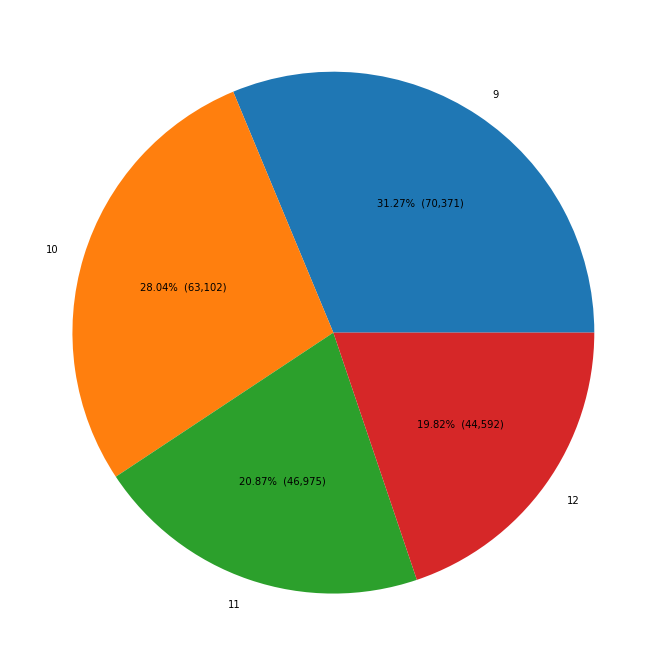

In [14]:
pct = lambda x: '{:.2f}%  ({:,.0f})'.format(x,x * sum(df['posts_count'])/100)
plt.figure(figsize=(12, 12))
plt.pie(df['posts_count'],
        labels=df['creation_month'],
        autopct=pct);

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [15]:
query = '''
WITH
tmp AS (SELECT EXTRACT(WEEK FROM creation_date)::int AS week_creation,
               creation_date
        FROM stackoverflow.posts
        WHERE user_id = (SELECT user_id
                         FROM stackoverflow.posts
                         GROUP BY user_id
                         ORDER BY COUNT(*) DESC
                         LIMIT 1)
          AND DATE_TRUNC('day', creation_date) BETWEEN '2008-10-01' AND '2008-10-31')
          
SELECT DISTINCT week_creation,
       LAST_VALUE(creation_date) OVER(PARTITION BY week_creation ORDER BY creation_date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS creation_date
FROM tmp
ORDER BY week_creation;
'''

df = pd.read_sql_query(query, con=engine) 
df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
